In [1]:
import csv
import random
import warnings
from timeit import default_timer as timer

import featuretools as ft
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from featuretools import selection
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.stochastic import sample
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")

In [2]:
test = pd.read_csv("../data/raw/test_rekrutacyjny_dane_walidacyjne.csv")
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (106895, 312)


,ROW_ID,Time_Period,v496,v495,v494,v493,v492,v491,v490,v489,...,v196,v195,v194,v193,v192,v191,v190,v189,v188,v187
0,1000001,121,0.25,0.75,0.50,0.50,0.0,0.75,0.5,0.25,...,0.75,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00
1,1000002,121,0.75,0.50,0.75,1.00,0.5,0.00,0.0,0.75,...,0.50,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50
2,1000003,121,1.00,0.00,0.00,1.00,1.0,1.00,1.0,1.00,...,0.00,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00
3,1000004,121,0.75,1.00,1.00,0.50,0.0,0.00,0.0,0.50,...,0.00,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25
4,1000005,121,0.25,0.50,0.50,0.25,1.0,0.50,0.5,0.25,...,0.50,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00


In [3]:
train = pd.read_csv("../data/raw/test_rekrytacyjny_dane_uczace.csv")
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (501808, 313)


,ROW_ID,Time_Period,v496,v495,v494,v493,v492,v491,v490,v489,...,v195,v194,v193,v192,v191,v190,v189,v188,v187,target
0,1,1,0.00,0.50,0.25,0.00,0.5,0.25,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.75
1,2,1,0.00,0.00,0.00,0.25,0.5,0.00,0.00,0.25,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,3,1,0.25,0.50,0.25,0.25,1.0,0.75,0.75,0.25,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.00
3,4,1,1.00,0.00,0.00,0.50,0.5,0.25,0.25,0.75,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.00
4,5,1,0.25,0.25,0.25,0.25,0.0,0.25,0.50,0.25,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


## Metrics

For this regression task, we will use two standard metrics:
- Mean Absolute Error (MAE): Average of the absolute value of the difference between predictions and the true values
- Root Mean Squared Error (RMSE): The square root of the average of the squared differences between the predictions and the true values.
The mean absolute error is more interpretable, but the root mean squared error penalizes larger errors more heavily. Either one may be appropriate depending on the situation. [Here is a discussion](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d).

In [4]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))

    return mae, rmse

### Naive Baseline
For a regression task, a simple naive baseline is to guess the median value on the training set for all testing cases. If our machine learning model cannot better this simple baseline, then perhaps we should try a different approach!

In [5]:
# Naive baseline is the median
median_pred = train["target"].median()
median_preds = [median_pred for _ in range(len(train["target"]))]
true = train["target"]


# Display the naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print(f"Median Baseline  MAE: {mb_mae:.4f}")
print(f"Median Baseline RMSE: {mb_rmse:.4f}")

Median Baseline  MAE: 0.2991
Median Baseline RMSE: 0.3530


### Feature Selection through Feature Importances

In [6]:
# Need to save the labels because aligning will remove this column
train_labels = train["target"]
train_ids = train["ROW_ID"]
test_ids = test["ROW_ID"]

train, test = train.align(test, join="inner", axis=1)

print("Training set full shape: ", train.shape)
print("Testing set full shape: ", test.shape)

Training set full shape:  (501808, 312)
Testing set full shape:  (106895, 312)


In [7]:
train = train.drop(columns=["ROW_ID"])
test = test.drop(columns=["ROW_ID"])

In [10]:
def identify_zero_importance_features(train, train_labels, iterations=2):
    """
    Identify zero importance features in a training dataset based on the
    feature importances from a gradient boosting model.

    Parameters
    --------
    train : dataframe
        Training features

    train_labels : np.array
        Labels for training data

    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """

    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMRegressor(
        objective="regression",
        n_estimators=10_000,
    )

    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(
            train, train_labels, test_size=0.25, random_state=i
        )

        # Train using early stopping
        model.fit(
            train_features,
            train_y,
            early_stopping_rounds=100,
            eval_set=[(valid_features, valid_y)],
            eval_metric=["mae", "rmse"],
            verbose=200,
        )

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations

    feature_importances = pd.DataFrame(
        {"feature": list(train.columns), "importance": feature_importances}
    ).sort_values("importance", ascending=False)

    # Find the features with zero importance
    zero_features = list(
        feature_importances[feature_importances["importance"] == 0.0]["feature"]
    )
    print(f"\nThere are {len(zero_features)} features with 0.0 importance")

    return zero_features, feature_importances


In [11]:
zero_features, feature_importances = identify_zero_importance_features(
    train, train_labels
)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.299542	valid_0's rmse: 0.35314	valid_0's l2: 0.124708
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.299233	valid_0's rmse: 0.352904	valid_0's l2: 0.124541

There are 262 features with 0.0 importance


In [12]:
def plot_feature_importances(df, threshold=0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    """

    plt.rcParams["font.size"] = 18

    # Sort features according to importance
    df = df.sort_values("importance", ascending=False).reset_index()

    # Normalize the feature importances to add up to one
    df["importance_normalized"] = df["importance"] / df["importance"].sum()
    df["cumulative_importance"] = np.cumsum(df["importance_normalized"])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(
        list(reversed(list(df.index[:15]))),
        df["importance_normalized"].head(15),
        align="center",
        edgecolor="k",
    )

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df["feature"].head(15))

    # Plot labeling
    plt.xlabel("Normalized Importance")
    plt.title("Feature Importances")
    plt.show()

    # Cumulative importance plot
    plt.figure(figsize=(8, 6))
    plt.plot(list(range(len(df))), df["cumulative_importance"], "r-")
    plt.xlabel("Number of Features")
    plt.ylabel("Cumulative Importance")
    plt.title("Cumulative Feature Importance")
    plt.show()

    importance_index = np.min(np.where(df["cumulative_importance"] > threshold))
    print(
        "%d features required for %0.2f of cumulative importance"
        % (importance_index + 1, threshold)
    )

    return df


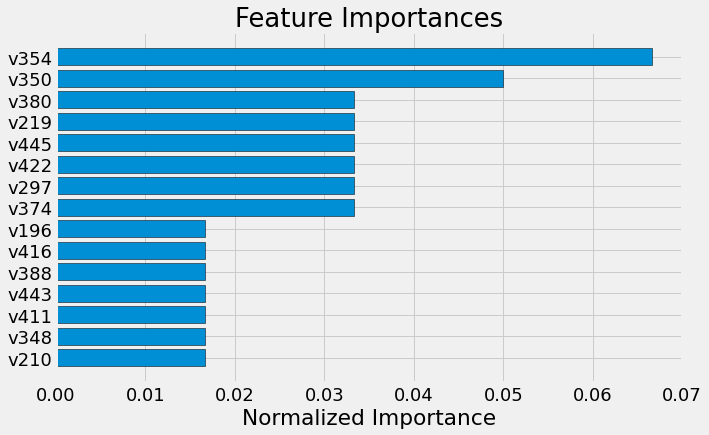

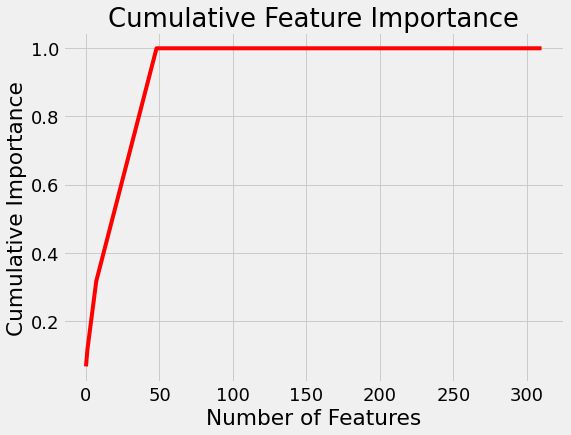

46 features required for 0.95 of cumulative importance


In [13]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold=0.95)

In [14]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(
    norm_feature_importances[
        norm_feature_importances["cumulative_importance"] < threshold
    ]["feature"]
)

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [15]:
train_small["target"] = train_labels
train_small["ROW_ID"] = train_ids

In [16]:
test_small["ROW_ID"] = test_ids

In [15]:
# train_small.to_csv('../data/processed/train_small.csv', index=False)
# test_small.to_csv('../data/processed/test_small.csv', index=False)

### Automated Feature Engineering

In [17]:
# Make an entityset
es = ft.EntitySet(id="records")


# Entities with a unique index
es = es.entity_from_dataframe(entity_id="train", dataframe=train_small, index="ROW_ID")

es = es.entity_from_dataframe(entity_id="test", dataframe=test_small, index="ROW_ID")

In [18]:
# Run and create the features
feature_matrix, feature_names = ft.dfs(
    entityset=es,
    target_entity="train",
    agg_primitives=["mean", "max", "min", "count", "sum"],
    trans_primitives=["cum_sum", "cum_mean", "percentile"],
    where_primitives=["mean", "sum"],
    max_depth=2,
    features_only=False,
    verbose=True,
    chunk_size=len(train),
    ignore_entities=["test"],
)

Built 322 features
Elapsed: 00:11 | Progress: 100%|██████████


In [19]:
# Run and create the features
feature_matrix_test, feature_names_test = ft.dfs(
    entityset=es,
    target_entity="test",
    agg_primitives=["mean", "max", "min", "count", "sum"],
    trans_primitives=["cum_sum", "cum_mean", "percentile"],
    where_primitives=["mean", "sum"],
    max_depth=2,
    features_only=False,
    verbose=True,
    chunk_size=len(test),
    ignore_entities=["train"],
)

Built 315 features
Elapsed: 00:02 | Progress: 100%|██████████


In [20]:
random.sample(feature_names, 10)

[<Feature: PERCENTILE(CUM_SUM(v365))>,
 <Feature: CUM_SUM(v359)>,
 <Feature: PERCENTILE(CUM_MEAN(v454))>,
 <Feature: CUM_SUM(v305)>,
 <Feature: CUM_MEAN(v398)>,
 <Feature: PERCENTILE(v262)>,
 <Feature: v262>,
 <Feature: PERCENTILE(v396)>,
 <Feature: PERCENTILE(v219)>,
 <Feature: CUM_MEAN(v443)>]

In [21]:
# Remove low information features
feature_matrix2 = selection.remove_low_information_features(feature_matrix)
print(
    "Removed %d features from training features"
    % (feature_matrix.shape[1] - feature_matrix2.shape[1])
)

feature_matrix_test2 = selection.remove_low_information_features(feature_matrix_test)
print(
    "Removed %d features from testing features"
    % (feature_matrix_test.shape[1] - feature_matrix_test2.shape[1])
)


Removed 0 features from training features
Removed 0 features from testing features


In [22]:
train_labels = feature_matrix["target"]
feature_matrix, feature_matrix_test = feature_matrix2.align(
    feature_matrix_test2, join="inner", axis=1
)
feature_matrix["target"] = train_labels

print("Final training shape: ", feature_matrix.shape)
print("Final testing shape: ", feature_matrix_test.shape)

feature_matrix.reset_index(level=0, inplace=True)
feature_matrix_test.reset_index(level=0, inplace=True)

Final training shape:  (501808, 316)
Final testing shape:  (106895, 315)


## Reduce Memory

In [23]:
# reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    print(f"Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%")

    return df

In [24]:
feature_matrix = reduce_mem_usage(feature_matrix)

Memory usage after optimization is: 390.51 MB
Decreased by 67.8%


In [27]:
feature_matrix_test = reduce_mem_usage(feature_matrix_test)

Memory usage after optimization is: 64.63 MB
Decreased by 74.9%


In [28]:
# feature_matrix.to_csv('../data/processed/feature_matrix.csv', index=False)
# feature_matrix_test.to_csv('../data/processed/feature_matrix_test.csv', index=False)

### Remove Collinear Variables
Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set. Clearly, these are three things we want to increase, so removing collinear variables is a useful step. We will establish an admittedly arbitrary threshold for removing collinear variables, and then remove one out of any pair of variables that is above that threshold.

The code below identifies the highly correlated variables based on the absolute magnitude of the Pearson correlation coefficient being greater than 0.9.

In [32]:
%%time

# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = feature_matrix.corr().abs()
corr_matrix.head()

CPU times: user 1min 17s, sys: 414 ms, total: 1min 17s
Wall time: 1min 17s


,ROW_ID,v354,v350,v380,v219,v445,v422,v297,v374,v196,...,PERCENTILE(CUM_MEAN(v388)),PERCENTILE(CUM_MEAN(v409)),PERCENTILE(CUM_MEAN(v416)),PERCENTILE(CUM_SUM(v445)),PERCENTILE(CUM_MEAN(v407)),PERCENTILE(CUM_MEAN(v396)),PERCENTILE(CUM_MEAN(v428)),PERCENTILE(CUM_SUM(v467)),PERCENTILE(CUM_SUM(v482)),target
ROW_ID,1.000000,0.000008,0.000004,0.000029,0.000007,0.000036,0.000014,0.000038,0.000008,9.133098e-07,...,0.020953,0.180263,0.066600,1.000000,0.160114,0.146258,0.126715,1.000000,1.000000,0.000033
v354,0.000008,1.000000,0.536020,0.002650,0.058898,0.238234,0.449110,0.055346,0.026525,1.383602e-01,...,0.002313,0.006655,0.000562,0.000008,0.000903,0.002303,0.000436,0.000008,0.000008,0.015362
v350,0.000004,0.536020,1.000000,0.147057,0.117614,0.260023,0.434379,0.206433,0.094235,9.465684e-02,...,0.000682,0.005981,0.001017,0.000002,0.000227,0.001000,0.001935,0.000002,0.000003,0.013104
v380,0.000029,0.002650,0.147057,1.000000,0.270684,0.111419,0.010864,0.272206,0.043968,3.078604e-01,...,0.000237,0.001582,0.001139,0.000028,0.000079,0.018208,0.001152,0.000028,0.000029,0.008054
v219,0.000007,0.058898,0.117614,0.270684,1.000000,0.102549,0.099710,0.122056,0.059284,1.512696e-01,...,0.000053,0.002215,0.000557,0.000006,0.000979,0.003981,0.002286,0.000006,0.000006,0.000761


In [33]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,ROW_ID,v354,v350,v380,v219,v445,v422,v297,v374,v196,...,PERCENTILE(CUM_MEAN(v388)),PERCENTILE(CUM_MEAN(v409)),PERCENTILE(CUM_MEAN(v416)),PERCENTILE(CUM_SUM(v445)),PERCENTILE(CUM_MEAN(v407)),PERCENTILE(CUM_MEAN(v396)),PERCENTILE(CUM_MEAN(v428)),PERCENTILE(CUM_SUM(v467)),PERCENTILE(CUM_SUM(v482)),target
ROW_ID,NaN,0.000008,0.000004,0.000029,0.000007,0.000036,0.000014,0.000038,0.000008,9.133098e-07,...,0.020953,0.180263,0.066600,1.000000,0.160114,0.146258,0.126715,1.000000,1.000000,0.000033
v354,NaN,NaN,0.536020,0.002650,0.058898,0.238234,0.449110,0.055346,0.026525,1.383602e-01,...,0.002313,0.006655,0.000562,0.000008,0.000903,0.002303,0.000436,0.000008,0.000008,0.015362
v350,NaN,NaN,NaN,0.147057,0.117614,0.260023,0.434379,0.206433,0.094235,9.465684e-02,...,0.000682,0.005981,0.001017,0.000002,0.000227,0.001000,0.001935,0.000002,0.000003,0.013104
v380,NaN,NaN,NaN,NaN,0.270684,0.111419,0.010864,0.272206,0.043968,3.078604e-01,...,0.000237,0.001582,0.001139,0.000028,0.000079,0.018208,0.001152,0.000028,0.000029,0.008054
v219,NaN,NaN,NaN,NaN,NaN,0.102549,0.099710,0.122056,0.059284,1.512696e-01,...,0.000053,0.002215,0.000557,0.000006,0.000979,0.003981,0.002286,0.000006,0.000006,0.000761


In [34]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print(f'There are {len(to_drop)} columns to remove.')

There are 194 columns to remove.


In [35]:
feature_matrix = feature_matrix.drop(columns=to_drop)
feature_matrix_test = feature_matrix_test.drop(columns=to_drop)

print('Training shape: ', feature_matrix.shape)
print('Testing shape: ', feature_matrix_test.shape)

Training shape:  (501808, 123)
Testing shape:  (106895, 122)


In [39]:
# feature_matrix.to_csv('../data/processed/fm_wo_collinear.csv', index=False)

In [40]:
# feature_matrix_test.to_csv('../data/processed/fm_test_wo_collinear.csv', index=False)

## Automated Hyperparameter Tuning

In [41]:
# Create a new file and open a connection
OUT_FILE = "../reports/bayes_test.csv"
of_connection = open(OUT_FILE, "w")
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ["loss", "hyperparameters", "iteration", "runtime", "score"]
writer.writerow(headers)
of_connection.close()

In [42]:
# Governing choices for search
N_FOLDS = 5
MAX_EVALS = 5

In [43]:
features = pd.read_csv("../data/processed/fm_wo_collinear.csv")

In [44]:
# Sample 16000 rows (10_000 for training, 6000 for testing)
features = features.sample(n=16_000, random_state=42)

# Only numeric features
features = features.select_dtypes("number")

# Extract the labels
labels = np.array(features["target"].astype(np.int32)).reshape((-1,))
features = features.drop(columns=["target", "ROW_ID"])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=6000, random_state=42
)

print("Train shape: ", train_features.shape)
print("Test shape: ", test_features.shape)

train_features.head()


Train shape:  (10000, 121)
Test shape:  (6000, 121)


,v354,v350,v380,v219,v445,v422,v297,v374,v196,v416,...,PERCENTILE(CUM_MEAN(v191)),PERCENTILE(CUM_MEAN(v395)),PERCENTILE(CUM_MEAN(v467)),PERCENTILE(CUM_MEAN(v262)),PERCENTILE(CUM_MEAN(v350)),PERCENTILE(CUM_MEAN(v388)),PERCENTILE(CUM_MEAN(v416)),PERCENTILE(CUM_MEAN(v407)),PERCENTILE(CUM_MEAN(v396)),PERCENTILE(CUM_MEAN(v428))
264663,0.75,1.00,0.50,1.00,0.50,0.75,0.75,0.50,0.25,0.00,...,0.6714,0.7880,0.3389,0.88960,0.6753,0.8413,0.86900,0.2742,0.2725,0.3433
245434,0.50,0.50,0.75,0.25,0.75,0.75,0.00,0.50,0.25,0.25,...,0.1016,0.5386,0.7770,0.69300,0.9224,0.2966,0.08320,0.7910,0.6816,0.7603
406086,0.00,0.25,0.75,0.50,0.50,0.00,0.00,0.25,0.25,1.00,...,0.4960,0.5244,0.5080,0.53560,0.4575,0.4956,0.53370,0.4153,0.6130,0.4905
60827,0.00,0.25,1.00,0.50,0.00,1.00,0.00,1.00,0.00,0.75,...,0.2954,0.3872,0.8145,0.11456,0.9707,0.4140,0.03186,0.8936,0.0687,0.4458
471925,1.00,0.75,1.00,0.25,1.00,0.75,0.50,0.75,0.25,0.25,...,0.5250,0.6120,0.3210,0.80860,0.6226,0.6780,0.49540,0.6973,0.2850,0.4316


In [45]:
model = lgb.LGBMRegressor(random_state=50)

# Training set
train_set = lgb.Dataset(train_features, label=train_labels)
test_set = lgb.Dataset(test_features, label=test_labels)


In [46]:
# Default hyperparamters
hyperparameters = model.get_params()

# Using early stopping to determine number of estimators.
del hyperparameters["n_estimators"]

# Perform cross validation with early stopping
cv_results = lgb.cv(
    hyperparameters,
    train_set,
    num_boost_round=10_000,
    nfold=N_FOLDS,
    metrics="mae",
    early_stopping_rounds=100,
    verbose_eval=False,
    seed=42,
)

In [47]:
# Highest score
best = cv_results["l1-mean"][-1]

# Standard deviation of best score
best_std = cv_results["l1-stdv"][-1]

print(
    f"The maximium MAE in cross validation was {best:.5f} with std of {best_std:.5f}."
)
print(f"The ideal number of iterations was {len(cv_results['l1-mean'])}.")

The maximium MAE in cross validation was 0.31776 with std of 0.00239.
The ideal number of iterations was 111.


In [48]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['l1-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)

LGBMRegressor(n_estimators=111, random_state=50)

In [49]:
# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict(test_features)
baseline_mae = mean_absolute_error(test_labels, preds)

print(f'The baseline model scores {baseline_mae:.5f} MAE on the test set.')

The baseline model scores 0.31391 MAE on the test set.


### Objective Function

In [50]:
def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""

    # Keep track of evals
    global ITERATION

    ITERATION += 1

    # Using early stopping to find number of trees trained
    if "n_estimators" in hyperparameters:
        del hyperparameters["n_estimators"]

    # Retrieve the subsample
    subsample = hyperparameters["boosting_type"].get("subsample", 1.0)

    # Extract the boosting type and subsample to top level keys
    hyperparameters["boosting_type"] = hyperparameters["boosting_type"]["boosting_type"]
    hyperparameters["subsample"] = subsample

    # Make sure parameters that need to be integers are integers
    for parameter_name in ["num_leaves", "subsample_for_bin", "min_child_samples"]:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()

    # Perform n_folds cross validation
    cv_results = lgb.cv(
        hyperparameters,
        train_set,
        num_boost_round=10_000,
        nfold=N_FOLDS,
        early_stopping_rounds=100,
        metrics="mae",
        seed=50,
    )

    run_time = timer() - start

    # Extract the best score
    best_score = cv_results["l1-mean"][-1]

    # Loss must be minimized
    loss = 1 - best_score

    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results["l1-mean"])

    # Add the number of estimators to the hyperparameters
    hyperparameters["n_estimators"] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, "a")
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {
        "loss": loss,
        "hyperparameters": hyperparameters,
        "iteration": ITERATION,
        "train_time": run_time,
        "status": STATUS_OK,
    }


In [51]:
# Create the learning rate
learning_rate = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.005), np.log(0.2))
}


#### We can visualize the learning rate by drawing 10_000 samples from the distribution.

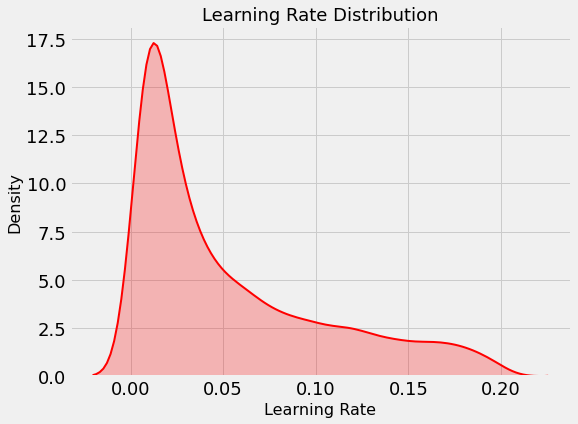

In [52]:
learning_rate_dist = []

# Draw 10_000 samples from the learning rate domain
for _ in range(10_000):
    learning_rate_dist.append(sample(learning_rate)["learning_rate"])

plt.figure(figsize=(8, 6))
sns.kdeplot(learning_rate_dist, color="red", linewidth=2, shade=True)
plt.title("Learning Rate Distribution", size=18)
plt.xlabel("Learning Rate", size=16)
plt.ylabel("Density", size=16);


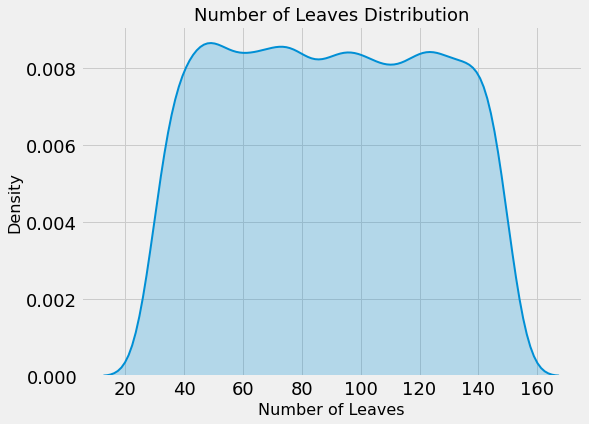

In [53]:
# Discrete uniform distribution
num_leaves = {"num_leaves": hp.quniform("num_leaves", 30, 150, 1)}
num_leaves_dist = []

# Sample 10_000 times from the number of leaves distribution
for _ in range(10_000):
    num_leaves_dist.append(sample(num_leaves)["num_leaves"])

# kdeplot
plt.figure(figsize=(8, 6))
sns.kdeplot(num_leaves_dist, linewidth=2, shade=True)
plt.title("Number of Leaves Distribution", size=18)
plt.xlabel("Number of Leaves", size=16)
plt.ylabel("Density", size=16);


In [54]:
# boosting type domain
boosting_type = {
    "boosting_type": hp.choice(
        "boosting_type",
        [
            {"boosting_type": "gbdt", "subsample": hp.uniform("subsample", 0.5, 1)},
            {"boosting_type": "dart", "subsample": hp.uniform("subsample", 0.5, 1)},
            {"boosting_type": "goss", "subsample": 1.0},
        ],
    )
}

# Draw a sample
hyperparams = sample(boosting_type)
hyperparams


{'boosting_type': {'boosting_type': 'dart', 'subsample': 0.5981945801253234}}

In [55]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = hyperparams["boosting_type"].get("subsample", 1.0)

# Extract the boosting type
hyperparams["boosting_type"] = hyperparams["boosting_type"]["boosting_type"]
hyperparams["subsample"] = subsample

hyperparams


{'boosting_type': 'dart', 'subsample': 0.5981945801253234}

### Complete Bayesian Domain

In [56]:
# Define the search space
space = {
    "boosting_type": hp.choice(
        "boosting_type",
        [
            {
                "boosting_type": "gbdt",
                "subsample": hp.uniform("gdbt_subsample", 0.5, 1),
            },
            {
                "boosting_type": "dart",
                "subsample": hp.uniform("dart_subsample", 0.5, 1),
            },
            {"boosting_type": "goss", "subsample": 1.0},
        ],
    ),
    "num_leaves": hp.quniform("num_leaves", 20, 150, 1),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.5)),
    "subsample_for_bin": hp.quniform("subsample_for_bin", 20_000, 300_000, 20_000),
    "min_child_samples": hp.quniform("min_child_samples", 20, 500, 5),
    "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
    "colsample_bytree": hp.uniform("colsample_by_tree", 0.6, 1.0),
    "is_unbalance": hp.choice("is_unbalance", [True, False]),
}


#### Example of Sampling from the Domain

In [57]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x["boosting_type"].get("subsample", 1.0)
x["boosting_type"] = x["boosting_type"]["boosting_type"]
x["subsample"] = subsample

x


{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9096077899515761,
 'is_unbalance': False,
 'learning_rate': 0.01578274634528609,
 'min_child_samples': 195.0,
 'num_leaves': 46.0,
 'reg_alpha': 0.6343187949953012,
 'reg_lambda': 0.029049073055069763,
 'subsample_for_bin': 40000.0,
 'subsample': 0.6483870583271683}

In [58]:
# Test the objective function
results = objective(sample(space))
print(f"The cross validation loss = {results['loss']:.5f}.")
print("The optimal number of estimators was {}.".format(
        results["hyperparameters"]["n_estimators"]
    )
)


The cross validation loss = 0.68094.
The optimal number of estimators was 31.


## Optimization Algorithm

In [59]:
# Create the algorithm
tpe_algorithm = tpe.suggest

In [60]:
# Record results
trials = Trials()

In [61]:
%%time
# Global variable
global ITERATION

ITERATION = 0

# Run optimization
best = fmin(
    fn=objective, space=space, algo=tpe.suggest, trials=trials, max_evals=MAX_EVALS
)

best


100%|██████████| 5/5 [12:58<00:00, 155.77s/trial, best loss: 0.5944967591817826]
CPU times: user 3h 26min 57s, sys: 20.6 s, total: 3h 27min 18s
Wall time: 12min 58s


{'boosting_type': 1,
 'colsample_by_tree': 0.7200057909889617,
 'dart_subsample': 0.8682562659849684,
 'is_unbalance': 0,
 'learning_rate': 0.2845657674234743,
 'min_child_samples': 195.0,
 'num_leaves': 71.0,
 'reg_alpha': 0.8465888279920283,
 'reg_lambda': 0.21817506765489925,
 'subsample_for_bin': 160000.0}